In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import warnings

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from IPython.display import Markdown, Image

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
%%html 
<style>
table {float:left; border-style: solid;}
</style>

Utils

In [3]:
def get_cm_based_measures(conf_matrix):
    TN = conf_matrix[0][0]
    FN = conf_matrix[1][0]
    TP = conf_matrix[1][1]
    FP = conf_matrix[0][1]
    
    # TPR = TP / TP + FN
    TPR = round(TP / (TP + FN), 6)
    # TNR = TN / TN + FP
    TNR = round(TN / (TN + FP), 6)
    # FPR = FP / TN + FP
    FPR = round(FP / (TN + FP), 6)
    # FNR = FN / TP + FN
    FNR = round(FN / (TP + FN), 6)
    # accuracy (TP + TN) / (TP + TN + FP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    # precision = TP / TP + FP
    precision = TP / (TP + FP)
    # recall = TP / TP + FN
    recall_pos = round(TP / (TP + FN), 6)
    recall_neg = round(TN / (TN + FP), 6)
    # avg class accuracy
    avg_acc = 1/2*(recall_pos+recall_neg)
    
    print( f'TPR: {TPR}   TNR: {TNR}   FPR: {FPR}   FNR: {FNR}   Accuracy: {accuracy}   Avg. Class Acc: {avg_acc}')
    
def k_fold_cross_val(classifier, kfolds, X, y):
    # Run classifier with cross-validation and plot ROC curves
    kfold = KFold(n_splits=kfolds,  shuffle=False)
    #classifier = DecisionTreeClassifier(max_depth=4)

    tprs = []
    aucs = []
    y_test = []
    y_predicted = []
    acc = []
    avg_acc = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    for i, (train, test) in enumerate(kfold.split(X)):
        classifier.fit(X.loc[train], y.loc[train])

        y_test.extend(y.loc[test])
        pred = classifier.predict(X.loc[test])
        y_predicted.extend(pred)

        viz = metrics.RocCurveDisplay.from_predictions(
            y.loc[test],
            pred,
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax[0],
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # accuracy score
        accuracy_test = metrics.accuracy_score(y.loc[test], pred)
        acc.append(accuracy_test)
        #print('Accuracy:', '{:.4f}'.format(accuracy_test))

        # average class accuracy score
        avg_acc_test = metrics.balanced_accuracy_score(y.loc[test], pred)
        avg_acc.append(avg_acc_test)
        #print('Average class accuracy:', '{:.4f}'.format(avg_acc_test))

    ax[0].plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[0].plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax[0].fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax[0].set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax[0].legend(loc="lower right")

    # acc and avg class accuracy
    mean_acc = sum(acc)/len(acc)
    print('Mean Accuracy:', '{:.4f}'.format(mean_acc))
    mean_avg_acc = sum(avg_acc)/len(avg_acc)
    print('Mean Average Class Accuracy:', '{:.4f}'.format(mean_avg_acc))
    
    # confusion matrix
    # confusion matrix-based performance measures
    CM = metrics.confusion_matrix(y_test, y_predicted)
    get_cm_based_measures(CM)

    cm_disp = metrics.ConfusionMatrixDisplay(CM).plot(cmap='Blues', ax=ax[1])
    ax[1].set_title("Confusion Matrix")

    plt.show()

### Dataset

In [4]:
# importing the dataset
data_path = 'data/'
file_name = 'titanic_clean_df.csv'
titanic_clean_df = pd.read_csv(data_path+file_name)
display(titanic_clean_df.shape)
titanic_clean_df.info()
titanic_clean_df.head()

(891, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Salutation   891 non-null    object 
 13  FamilySize   891 non-null    int64  
 14  FareBand     891 non-null    object 
 15  AgeBand      891 non-null    object 
 16  FSizeBand    891 non-null    object 
dtypes: float64(2), int64(6), object(9)
memory usage: 118.5+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation,FamilySize,FareBand,AgeBand,FSizeBand
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,"(-0.001, 7.91]","(21.0, 29.0]",small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1,"(31.0, 512.329]","(36.75, 80.0]",small
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,"(7.91, 14.454]","(21.0, 29.0]",alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1,"(31.0, 512.329]","(29.0, 36.75]",small
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,"(7.91, 14.454]","(29.0, 36.75]",alone


In [5]:
# importing the dataset
data_path = 'data/'
file_name = 'titanic_preproc_df.csv'
titanic_df = pd.read_csv(data_path+file_name)
display(titanic_df.shape)
titanic_df.info()
titanic_df.head()

(891, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Survived    891 non-null    int64
 1   Pclass      891 non-null    int64
 2   Salutation  891 non-null    int64
 3   FareBand    891 non-null    int64
 4   AgeBand     891 non-null    int64
 5   FSizeBand   891 non-null    int64
dtypes: int64(6)
memory usage: 41.9 KB


,Survived,Pclass,Salutation,FareBand,AgeBand,FSizeBand
0,0,3,0,1,2,2
1,1,1,3,4,4,2
2,1,3,4,2,2,1
3,1,1,3,4,3,2
4,0,3,0,2,3,1


___
### Models

Models with default parameters

**1. Decision Trees**

Mean Accuracy: 0.8193
Mean Average Class Accuracy: 0.7980
TPR: 0.69883   TNR: 0.894353   FPR: 0.105647   FNR: 0.30117   Accuracy: 0.819304152637486   Avg. Class Acc: 0.7965914999999999


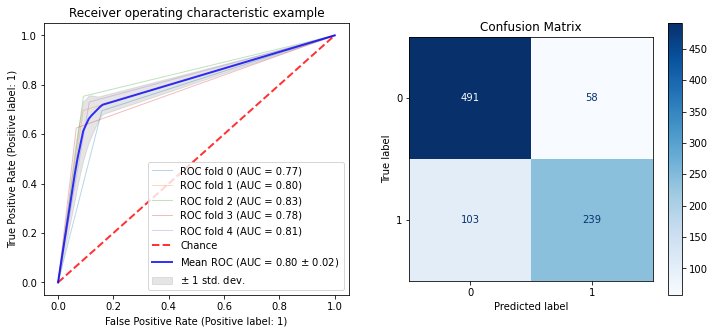

In [8]:
# k-fold
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']

classifier = DecisionTreeClassifier() # with default params
k_fold_cross_val(classifier, 5, X, y)

**2. Random Forest**

Mean Accuracy: 0.8227
Mean Average Class Accuracy: 0.8049
TPR: 0.722222   TNR: 0.885246   FPR: 0.114754   FNR: 0.277778   Accuracy: 0.8226711560044894   Avg. Class Acc: 0.803734


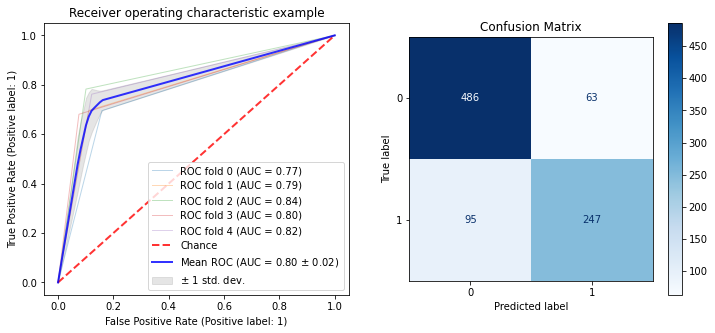

In [10]:
# k-fold
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']

classifier = RandomForestClassifier() # with default params
k_fold_cross_val(classifier, 5, X, y)

**3. AdaBoost**

Mean Accuracy: 0.8238
Mean Average Class Accuracy: 0.8133
TPR: 0.75731   TNR: 0.865209   FPR: 0.134791   FNR: 0.24269   Accuracy: 0.8237934904601572   Avg. Class Acc: 0.8112595


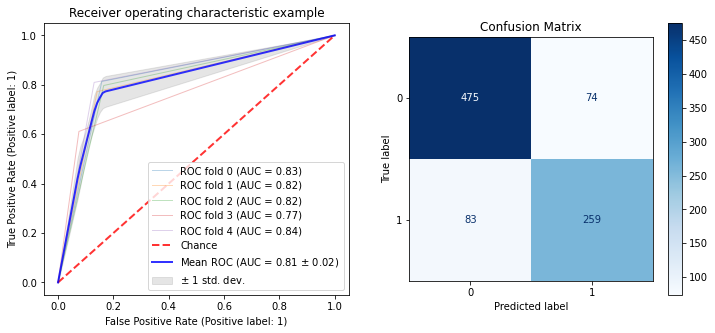

In [12]:
# k-fold
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']

classifier = AdaBoostClassifier() # with default params
k_fold_cross_val(classifier, 5, X, y)

**4. Gradient Boosting**

Mean Accuracy: 0.8395
Mean Average Class Accuracy: 0.8222
TPR: 0.745614   TNR: 0.897996   FPR: 0.102004   FNR: 0.254386   Accuracy: 0.8395061728395061   Avg. Class Acc: 0.821805


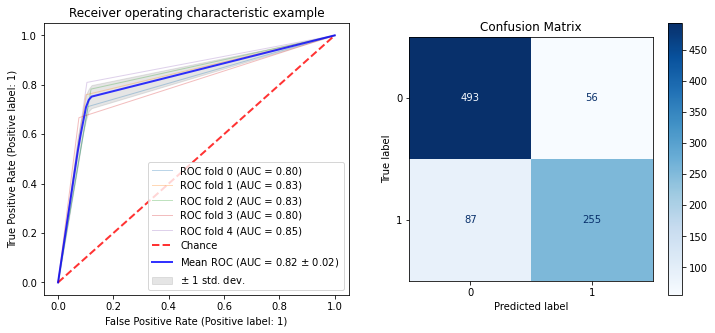

In [14]:
# k-fold
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']

classifier = GradientBoostingClassifier() # with default params
k_fold_cross_val(classifier, 5, X, y)

**5. Logistic Regression**

Mean Accuracy: 0.7789
Mean Average Class Accuracy: 0.7587
TPR: 0.663743   TNR: 0.850638   FPR: 0.149362   FNR: 0.336257   Accuracy: 0.7789001122334456   Avg. Class Acc: 0.7571905


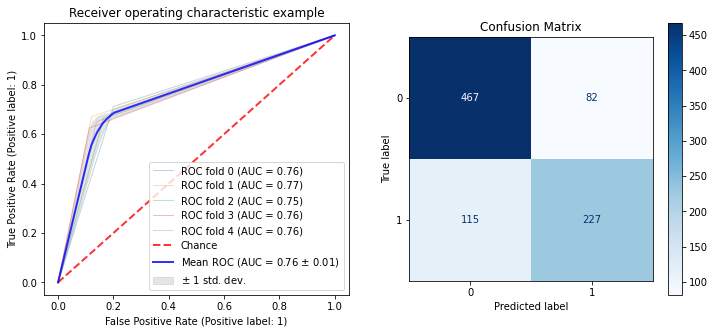

In [17]:
# k-fold
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']

# scaling the data
X[features] = StandardScaler().fit_transform(X[features])

classifier = LogisticRegression() # with default params
k_fold_cross_val(classifier, 5, X, y)

**6. SVM**

Mean Accuracy: 0.8160
Mean Average Class Accuracy: 0.8029
TPR: 0.733918   TNR: 0.867031   FPR: 0.132969   FNR: 0.266082   Accuracy: 0.8159371492704826   Avg. Class Acc: 0.8004745


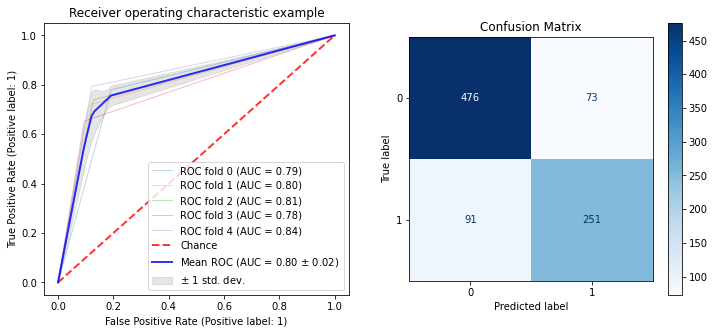

In [19]:
# k-fold
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']

# scaling the data
X[features] = StandardScaler().fit_transform(X[features])

classifier = SVC() # with default params
k_fold_cross_val(classifier, 5, X, y)

**7. k-nearest neighbors**

Mean Accuracy: 0.8093
Mean Average Class Accuracy: 0.7983
TPR: 0.745614   TNR: 0.848816   FPR: 0.151184   FNR: 0.254386   Accuracy: 0.8092031425364759   Avg. Class Acc: 0.797215


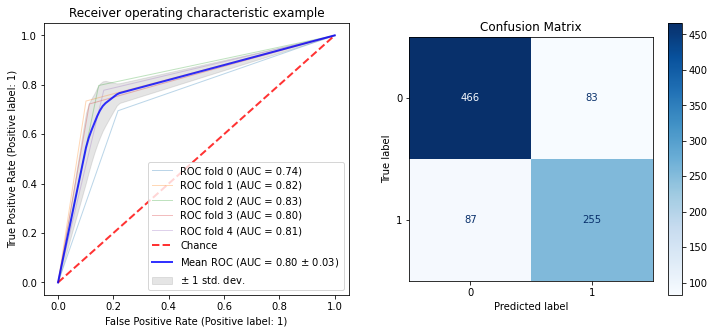

In [21]:
# k-fold
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']

# scaling the data
X[features] = StandardScaler().fit_transform(X[features])

classifier = KNeighborsClassifier() # with default params
k_fold_cross_val(classifier, 5, X, y)

**8. Naive Bayes**

Mean Accuracy: 0.7723
Mean Average Class Accuracy: 0.7578
TPR: 0.690058   TNR: 0.823315   FPR: 0.176685   FNR: 0.309942   Accuracy: 0.7721661054994389   Avg. Class Acc: 0.7566865


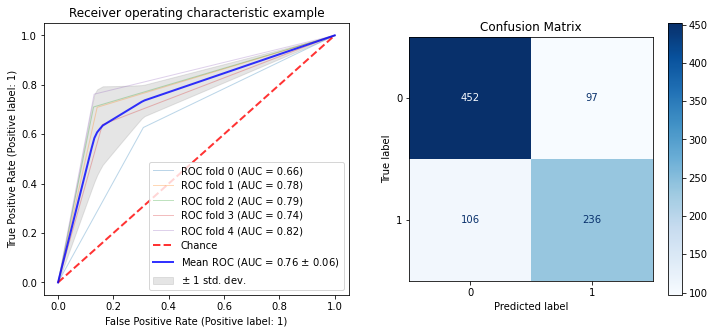

In [23]:
# k-fold
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']

classifier = CategoricalNB() # with default params
k_fold_cross_val(classifier, 5, X, y)

**9. Artificial neural network with two hidden layers**

Mean Accuracy: 0.8148
Mean Average Class Accuracy: 0.7943
TPR: 0.704678   TNR: 0.883424   FPR: 0.116576   FNR: 0.295322   Accuracy: 0.8148148148148148   Avg. Class Acc: 0.7940510000000001


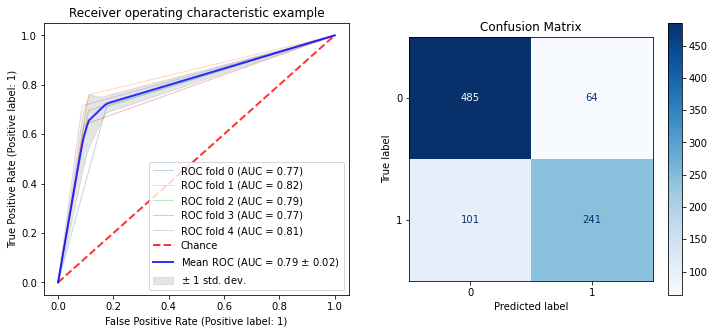

In [25]:
# k-fold
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = titanic_df[features], titanic_df['Survived']

classifier = MLPClassifier(random_state=1, hidden_layer_sizes=(100,100), max_iter=300)
k_fold_cross_val(classifier, 5, X, y)